In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/lab8.csv')
df.columns = ['X_1', 'X_2', 'X_3', 'X_4', 'Category']
df.head()

,X_1,X_2,X_3,X_4,Category
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [3]:
X = (df.drop(columns='Category')).to_numpy()
X = X.T
mu = X.mean(axis=1, keepdims=True)
X_centered = X - mu
label_map = {name:i for i, name in enumerate(sorted(df["Category"].unique()))}
y_true = df['Category'].map(label_map).to_numpy()

In [4]:
X_centered.shape

(4, 149)

In [5]:
n_samples = X_centered.shape[1]
# the data covariance matrix
C = (X_centered@X_centered.T)/n_samples
C

array([[ 0.68196027, -0.03702851,  1.2618364 ,  0.5118882 ],
       [-0.03702851,  0.18666006, -0.3146052 , -0.11497185],
       [ 1.2618364 , -0.3146052 ,  3.07559119,  1.2804725 ],
       [ 0.5118882 , -0.11497185,  1.2804725 ,  0.57567587]])

In [6]:
# eigenvalue and eigenvector decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C) # eigh returns in ascending order
# in descending order
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

In [7]:
# (c) PCA projection to k=2
k = 2
eigenvectors_k = eigenvectors[:, :k]
W = eigenvectors_k.T
Y = W @ X_centered
Y_T = Y.T

In [13]:
W

array([[-0.36263433,  0.08122848, -0.85629752, -0.35868209],
       [ 0.6558202 ,  0.73001455, -0.17703033, -0.07509244]])

In [8]:
W.shape, Y_T.shape

((2, 4), (149, 2))

In [9]:
# (d) Reconstruction
U = eigenvectors_k
X_hat = U @ Y

In [10]:
# (e) Reconstruction error for k=1,2,3
def recon_error_for_k(k_val: int) -> float:
    eigenvectors_k = eigenvectors[:, :k_val]
    W_k = eigenvectors_k.T
    Y_k = W_k @ X_centered
    X_hat_k = eigenvectors_k @ Y_k
    err = np.sum((X_centered - X_hat_k)**2) / n_samples
    return err

recon_err_k1 = recon_error_for_k(1)
recon_err_k2 = recon_error_for_k(2)
recon_err_k3 = recon_error_for_k(3)

recon_err_k1, recon_err_k2, recon_err_k3

(np.float64(0.3437176926773697),
 np.float64(0.10220375036695947),
 np.float64(0.023683020182339625))

In [11]:
# (f) Spectral Clustering
from sklearn.cluster import SpectralClustering
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def clustering_accuracy(y_true, y_pred) -> float:
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm.max() - cm)
    matched = cm[row_ind, col_ind].sum()
    return 100.0 * matched / len(y_true)

X_for_clust = X_centered.T
sc_before = SpectralClustering(n_clusters=3, affinity="rbf", assign_labels="kmeans", random_state=0)
y_pred_before = sc_before.fit_predict(X_for_clust)
acc_before = clustering_accuracy(y_true, y_pred_before)

sc_after = SpectralClustering(n_clusters=3, affinity="rbf", assign_labels="kmeans", random_state=0)
y_pred_after = sc_after.fit_predict(Y_T)
acc_after = clustering_accuracy(y_true, y_pred_after)

acc_before, acc_after

(np.float64(89.93288590604027), np.float64(89.93288590604027))

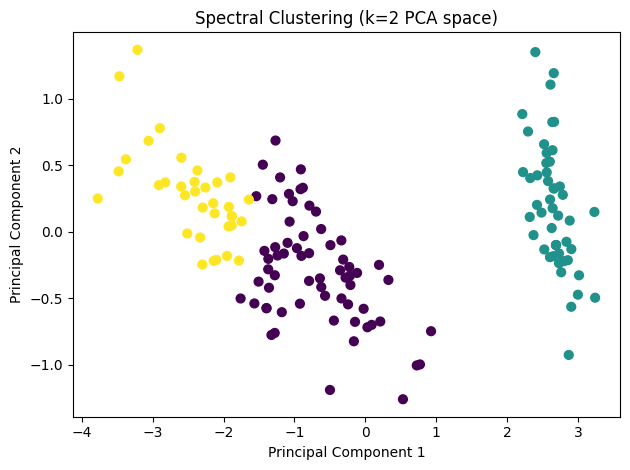

In [12]:
# (g) Plotting the clusters after dimensionality reduction
plt.scatter(Y_T[:, 0], Y_T[:, 1], c=y_pred_after, s=40)
plt.title("Spectral Clustering (k=2 PCA space)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()